# Plots for the 2MDM analysis

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import re,os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from scipy.interpolate import griddata,interp1d
from itertools import product
import pyslha

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu_r']

### Load Relic Density scan 

In [2]:
scanLabel = 'scan1'
scanSummary = os.path.join('../data/maddmOutput/',scanLabel,'output/scan_run_01.txt')
with open(scanSummary,'r') as f:
    headerLines = [l for l in f.readlines() if l.strip() and l.strip()[0] == '#']
columnLabels = {eval(re.sub(r'\b0', '',h.split(':')[0].replace('[','').replace(']','').replace('#',''))) : 
                     h.split(':')[1].replace('\n','').strip().replace('%','pc') for h in headerLines}
header = ['']*len(columnLabels)
for i,label in columnLabels.items():
    header[i-1] = label
relicData = pd.read_csv(scanSummary,names=header,
                        comment='#',delimiter='\t',index_col=False)
# Remove unused columns:
relicData.drop(columns=[c for c in relicData.columns if 'pc_relic' in c]+['Nevents','smearing','xsi','x_f','sigmav(xf)'],inplace=True)
# Rename columns:
renameDict = {'Omegah^2' : 'Omegah2', 'mass#9000006' : 'mChi', 'mass#9900032' : 'mZp', 'mass#9900026' : 'mS'}
relicData.rename(columns=renameDict,inplace=True)
print(relicData.columns)

Index(['run', 'mChi', 'mZp', 'Omegah2', 'sigmaN_SI_p', 'lim_sigmaN_SI_p',
       'sigmaN_SI_n', 'lim_sigmaN_SI_n', 'sigmaN_SD_p', 'lim_sigmaN_SD_p',
       'sigmaN_SD_n', 'lim_sigmaN_SD_n'],
      dtype='object')


### Load LZ limits

In [3]:
LZ_curve = np.genfromtxt('../data/LZ_2207.03764_SI_limits.txt',names=True)
LZ_limitF = np.vectorize(interp1d(LZ_curve['mass'],LZ_curve['limit']))

In [4]:
# Compute r values:
relicData['r_omega'] = relicData['Omegah2']/0.12
dd_rescaling = (np.minimum(1.0,relicData['r_omega']))
relicData['r_SI_p'] = dd_rescaling*relicData['sigmaN_SI_p']/relicData['lim_sigmaN_SI_p']
relicData['r_SI_n'] = dd_rescaling*relicData['sigmaN_SI_n']/relicData['lim_sigmaN_SI_n']
relicData['r_SD_p'] = dd_rescaling*relicData['sigmaN_SD_p']/relicData['lim_sigmaN_SD_p']
relicData['r_SD_n'] = dd_rescaling*relicData['sigmaN_SD_n']/relicData['lim_sigmaN_SD_n']
relicData['r_SI_LZ'] = dd_rescaling*relicData['sigmaN_SI_p']/LZ_limitF(relicData['mChi'])
relicData['r_dm'] = relicData[['r_omega','r_SI_p','r_SI_n','r_SD_p','r_SD_n','r_SI_LZ']].values.max(1)

### Get Model Parameters

In [5]:
modelPars = pyslha.readSLHAFile(os.path.join('../data/maddmOutput',scanLabel,'Cards/param_card.dat'))
gchi = modelPars.blocks['NPINPUTS'][1]
gq = modelPars.blocks['NPINPUTS'][2]
sina = modelPars.blocks['NPINPUTS'][3]
mS = modelPars.blocks['MASS'][9900026]


textstr = '\n'.join((
    r'$m_S =$ %1.2f TeV' %(mS/1e3),
    r'$g_q =$ %1.2f' %gq,
    r'$g_\chi =$ %1.2f' %gchi,
    r'$\sin\alpha =$ %1.1f' %sina))


### Load ATLAS curve

In [6]:
atlasCurve1 = np.array(list(zip([112.70553064275038, 178.77428998505232, 268.16143497757844, 342.0029895366218, 423.61733931240656, 509.118086696562, 563.5276532137518, 617.9372197309417, 680.1195814648729, 726.7563527653214, 788.9387144992526, 847.2346786248131, 1053.2137518684603, 1173.6920777279522, 1282.5112107623318, 1402.9895366218236, 1573.9910313901344, 1752.7653213751867, 1915.9940209267563, 2129.745889387145],[4.267425320056899, 19.203413940256045, 46.941678520625885, 72.54623044096728, 108.81934566145091, 136.55761024182075, 155.7610241820768, 174.96443812233284, 181.3655761024182, 204.83641536273115, 226.17354196301562, 258.17923186344234, 358.4637268847795, 422.47510668563297, 477.95163584637265, 535.5618776671407, 612.375533428165, 695.5903271692745, 772.4039829302986, 872.6884779516357])))
atlasCurve2 = np.array(list(zip([897.7578475336322, 862.780269058296, 823.9162929745889, 804.4843049327354, 788.9387144992526, 785.0523168908819, 804.4843049327354, 855.0074738415545, 913.3034379671151, 963.8266068759342, 1014.3497757847533, 1080.4185351270553, 1134.8281016442452, 1189.2376681614348, 1247.5336322869955, 1321.3751868460388, 1418.5351270553065],[889.7581792318633, 840.6827880512091, 793.7411095305831, 766.0028449502133, 733.9971550497866, 706.2588904694167, 684.9217638691322, 676.3869132290184, 674.25320056899, 687.0554765291606, 701.9914651493598, 725.4623044096728, 748.9331436699857, 770.2702702702702, 798.00853485064, 832.1479374110952, 872.6884779516357])))

/tmp/ipykernel_24145/1963835497.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


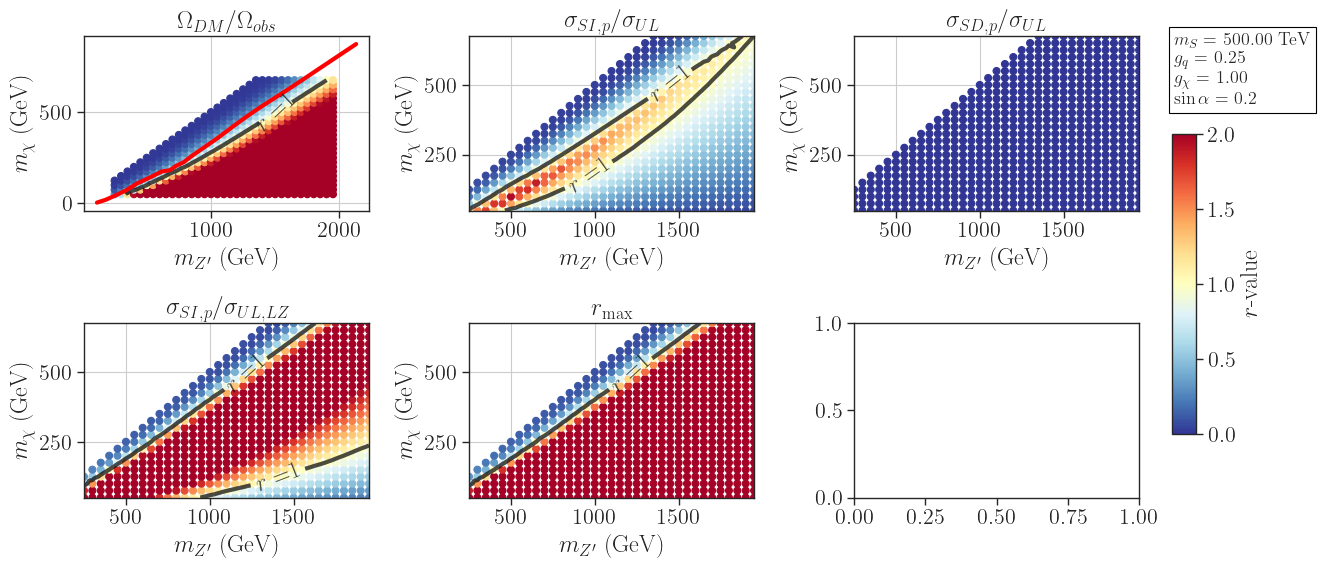

In [7]:
xLabels = ['mZp']
yLabels = ['mChi']
zLabels = ['r_omega','r_SI_p','r_SD_p','r_SI_LZ','r_dm']
x_labels = [r'$m_{Z^\prime}$ (GeV)']
y_labels = [r'$m_{\chi}$ (GeV)']
z_labels = [r'$\Omega_{DM}/\Omega_{obs}$',r'$\sigma_{SI,p}/\sigma_{UL}$',
            r'$\sigma_{SD,p}/\sigma_{UL}$',r'$\sigma_{SI,p}/\sigma_{UL,LZ}$',r'$r_{\rm max}$']

allPlots = list(product(xLabels,yLabels,zLabels))
allLabels = list(product(x_labels,y_labels,z_labels))
nplots = len(allPlots)

fig,axarr = plt.subplots(nrows=int(nplots/3)+1,ncols=3,figsize=(12,6))
axarr = np.array(axarr).reshape(-1)

for iplot,(xLabel,yLabel,zLabel) in enumerate(allPlots):
    ax = axarr[iplot]

    p = ax.scatter(relicData[xLabel],relicData[yLabel],c=relicData[zLabel],s=25,
            cmap=cm, vmin=0.0,vmax=2.0)

    pts = np.array([y for y in product(np.unique(relicData[xLabel]),np.unique(relicData[yLabel]))])
    rPts = griddata(list(zip(relicData[xLabel],relicData[yLabel])),relicData[zLabel],pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
    cs = ax.tricontour(pts[:,0],pts[:,1], rPts, levels=[1.0], alpha=0.7,linewidths=3,colors='black')
    ax.clabel(cs, levels= [1.0], inline=True, fmt=r'$r = $%1.0f')
    if zLabel == 'r_omega':
        ax.plot(atlasCurve1[:,0],atlasCurve1[:,1],color='red',linewidth=3)
        # ax.plot(atlasCurve2[:,0],atlasCurve2[:,1],color='red',linewidth=3)
    
    
    ax.set_xlabel(allLabels[iplot][0])
    ax.set_ylabel(allLabels[iplot][1])
    ax.set_title(allLabels[iplot][2])
    # ax.set_xlim(50.0,1.1*x.max())
    # ax.set_ylim(5.0,1.1*y.max())
    # ax.legend()
    ax.grid()

fig.subplots_adjust(right=0.92,top=1.1)
cbar_ax = fig.add_axes([0.99, 0.25, 0.02, 0.5]) 
fig.colorbar(p,label=r'$r$-value',cax=cbar_ax)

plt.text(0.1,1.1,textstr,fontsize=13,bbox=dict(facecolor='white', edgecolor='black'),
            transform = plt.gca().transAxes)
plt.tight_layout()
plt.show()    